# Imports

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import import torch.nn.functional as F
import timm

In [ ]:
from tqdm import tqdm
from timeit import default_timer as timer
import matplotlib.pyplot as plt

#Data

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize(mean=0.5, std=0.5)])

In [ ]:
# Download training and validation data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

# Dividing training data into two training and validation parts
train_size = int(0.67 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Download test data
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

#create data loader for train and validation data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=50,shuffle=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12999741.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Model

## creat model

In [ ]:
# load coat_lite_small model
model = timm.create_model('coat_lite_small', pretrained=True,img_size=(224, 224, 3))

In [ ]:
# Freeze all layers except for the layers of the Last SerialBlock of serial blocks 4 and later
for name, param in model.named_parameters():
    if 'blocks.4' in name:
        break
    param.requires_grad = False

In [ ]:
#add flatten، dense،dropout layers to model
model.head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(model.head.in_features, 256),
    nn.ELU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 10)
)

## Train model

In [ ]:
def train_step(model,data_loader,loss_fn, optimizer, accuracy_fn,device):

    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(), pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

    return train_loss.item(), train_acc


In [ ]:
def test_step(model, data_loader,loss_fn,accuracy_fn, device):

    model.to(device)
    model.eval()
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(true=y.cpu(),pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(train_acc=test_acc/counter, train_loss=test_loss.item()/counter, refresh=True)

        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)

    return test_loss.item(), test_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0000001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [ ]:

train_epoch_loss_model = []
train_epoch_accuracy_model = []
val_epoch_loss_model = []
val_epoch_accuracy_model = []

train_time_start = timer()

epochs = 20
for epoch in range(epochs):
    print("EPOCH {}/{} :".format(epoch +1, epochs))
    train_loss, train_acc = train_step(data_loader=trainloader,
                                              model=model,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              accuracy_fn=accuracy_fn,
                                              device=device
                                              )
    val_loss, val_acc = test_step(data_loader=valloader,
                                     model=model,
                                     loss_fn=loss_fn,
                                     accuracy_fn=accuracy_fn,
                                      device=device
                                      )

    train_epoch_loss_model.append(train_loss)
    train_epoch_accuracy_model.append(train_acc)
    val_epoch_loss_model.append(val_loss)
    val_epoch_accuracy_model.append(val_acc)

train_time_end = timer()
total_time = train_time_end - train_time_start
print(f"\n\nTrain time: {total_time:.3f} seconds")

EPOCH 1/20 :


   test: 100%|██████████| 330/330 [01:48<00:00,  3.05it/s, train_acc=11, train_loss=2.32]


EPOCH 2/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=12, train_loss=2.31]


EPOCH 3/20 :


   test: 100%|██████████| 330/330 [01:48<00:00,  3.05it/s, train_acc=13.1, train_loss=2.3]


EPOCH 4/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=14.3, train_loss=2.29]


EPOCH 5/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=15.6, train_loss=2.28]


EPOCH 6/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=17.1, train_loss=2.27]


EPOCH 7/20 :


   test: 100%|██████████| 330/330 [01:48<00:00,  3.05it/s, train_acc=18.1, train_loss=2.26]


EPOCH 8/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=19.6, train_loss=2.25]


EPOCH 9/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=21.5, train_loss=2.25]


EPOCH 10/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.07it/s, train_acc=22.5, train_loss=2.24]


EPOCH 11/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.08it/s, train_acc=24.1, train_loss=2.23]


EPOCH 12/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=25.5, train_loss=2.22]


EPOCH 13/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.07it/s, train_acc=27.3, train_loss=2.21]


EPOCH 14/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.07it/s, train_acc=28.9, train_loss=2.2]


EPOCH 15/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.08it/s, train_acc=30.6, train_loss=2.19]


EPOCH 16/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=32.4, train_loss=2.18]


EPOCH 17/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=34.3, train_loss=2.17]


EPOCH 18/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=35.9, train_loss=2.17]


EPOCH 19/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=37.9, train_loss=2.16]


EPOCH 20/20 :


   test: 100%|██████████| 330/330 [01:47<00:00,  3.06it/s, train_acc=39.5, train_loss=2.15]



Train time: 6559.473 seconds


# plot

In [ ]:
import seaborn as sns

In [ ]:
def accloss_plots(train_loss=train_epoch_loss_model,
                  val_loss=val_epoch_loss_model,
                  train_acc=train_epoch_accuracy_model,
                  val_acc=val_epoch_accuracy_model):

    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(val_loss , 'g', label='Validation')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(val_acc, 'g', label='Validation')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.show();

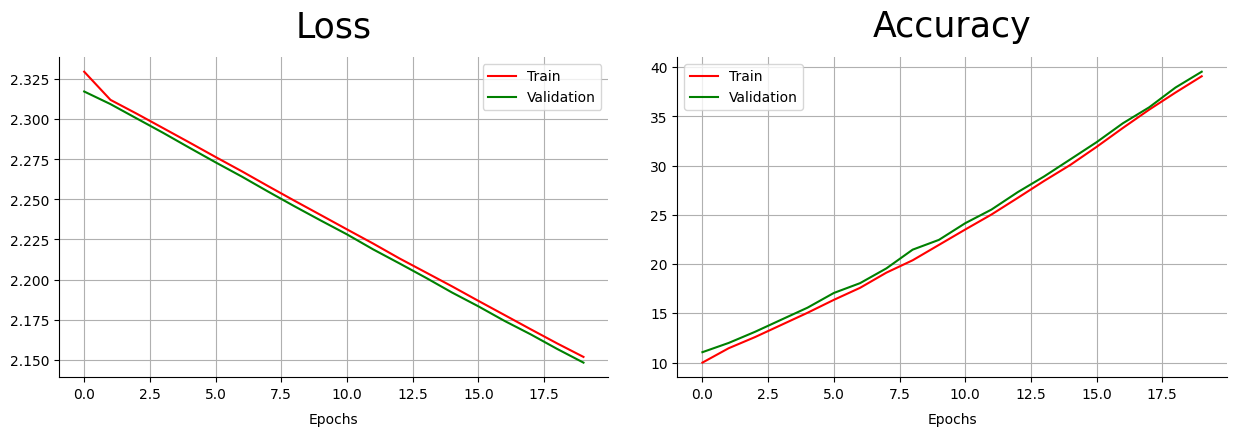

In [ ]:
accloss_plots()